In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df1_train = pd.read_parquet('../data/final/2022_data.parquet')
df2_train = pd.read_parquet('../data/final/2023_data.parquet')
df_val = pd.read_parquet('../data/final/2024_data.parquet')
df_train = pd.concat([df1_train, df2_train], ignore_index=True)

In [3]:
categorical = ['date', 'dayofweek', 'away_league', 'home_league', 'park_id']
numerical = ['home_OPS_blend', 'home_FIP_blend', 'home_FPCT_blend', 'away_OPS_blend', 'away_FIP_blend', 'away_FPCT_blend']
target = ['home_won']

In [4]:
vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(df_train[categorical+numerical].to_dict(orient='records'))
all_features = vec.get_feature_names_out()

In [5]:
X_val = vec.transform(df_val[categorical+numerical].to_dict(orient='records'))

In [6]:
y_train = df_train[target].values.ravel()
y_val = df_val[target].values.ravel()

In [7]:
for depth in [1,3,5,7,10]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.523
   3 -> 0.544
   5 -> 0.543
   7 -> 0.538
  10 -> 0.498


In [8]:
for min_samples_leaf in [1,3, 5,10,15]:
    dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (min_samples_leaf, auc))

   1 -> 0.543
   3 -> 0.543
   5 -> 0.544
  10 -> 0.544
  15 -> 0.544


In [9]:
y_pred_train = dt.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_train

0.6260854396688835

In [10]:
scores = []

for d in [2,3,5,7,10]:
    rf = RandomForestClassifier(n_estimators=200, max_depth=d, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((d, auc))

In [11]:
y_pred_train = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_train

0.9161333311592268

In [12]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'auc'])

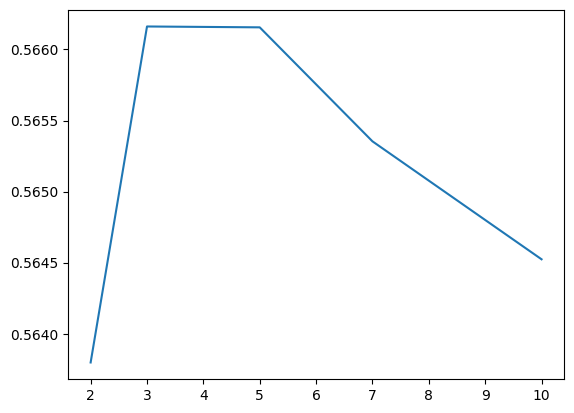

In [13]:
plt.plot(df_scores.max_depth, df_scores.auc)

In [14]:
scores = []

for l in [5,7,10, 15, 20]:
    rf = RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=l, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((l, auc))

In [15]:
df_scores = pd.DataFrame(scores, columns=['min_sample_leaf', 'auc'])

In [15]:
y_pred_train = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_train

0.6235480195588058

In [17]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=5, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.5665564501777547

In [7]:
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
import pickle

/workspaces/saber-metrics-machine-learning/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


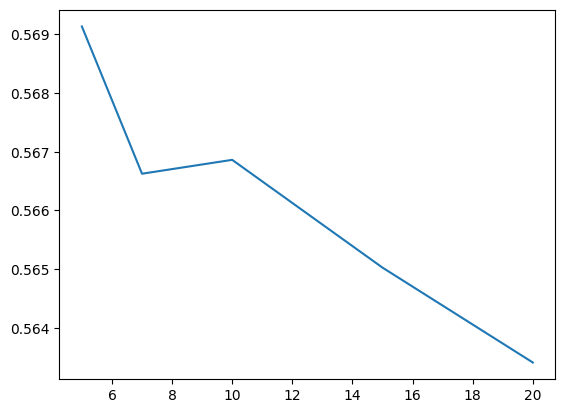

In [16]:
plt.plot(df_scores.min_sample_leaf, df_scores.auc)

In [8]:
search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 3, 7, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50)),
        'learning_rate': hp.loguniform('learning_rate', -7, -3),
        'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.05),
        'reg_lambda': hp.quniform('reg_lambda', 1.0, 10.0, 0.5),
        'min_child_weight': hp.quniform('min_child_weight', 10, 30, 2),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.9, 0.05),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42
    }

In [9]:
score = []
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    y_pred = xgb_model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred_proba)
    score.append({'params': params, 'auc': auc})
    
    return {'loss': auc, 'status': STATUS_OK}

In [10]:
rstate = np.random.default_rng(42)
num_trials = 15
best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

100%|█████| 15/15 [00:04<00:00,  3.39trial/s, best loss: 0.5493345577597344]


In [21]:
best_result

{'colsample_bytree': 0.75,
 'learning_rate': 0.008671943925267897,
 'max_depth': 7.0,
 'min_child_weight': 24.0,
 'n_estimators': 250.0,
 'reg_alpha': 0.25,
 'reg_lambda': 8.0}

In [22]:
xgb_score_df = pd.DataFrame(score)

In [23]:
params_df = pd.json_normalize(xgb_score_df['params'])
full_df = pd.concat([xgb_score_df.drop(columns=['params']), params_df], axis=1)

In [24]:
full_df.sort_values(by='auc', ascending=False).head(5)

,auc,colsample_bytree,eval_metric,learning_rate,max_depth,min_child_weight,n_estimators,objective,random_state,reg_alpha,reg_lambda
11,0.561685,0.80,auc,0.047437,4,16.0,100,binary:logistic,42,0.65,8.0
7,0.560861,0.80,auc,0.017428,4,16.0,400,binary:logistic,42,0.85,1.5
3,0.558678,0.65,auc,0.006758,3,24.0,300,binary:logistic,42,0.30,4.5
6,0.558447,0.65,auc,0.040390,5,28.0,100,binary:logistic,42,1.00,7.5
13,0.558100,0.75,auc,0.001816,6,28.0,100,binary:logistic,42,0.50,1.5


In [18]:
best_result_clean = {
    'max_depth': int(best_result['max_depth']),
    'n_estimators': int(best_result['n_estimators']),
    'min_child_weight': float(best_result['min_child_weight']),
    'colsample_bytree': float(best_result['colsample_bytree']),
    'learning_rate': float(best_result['learning_rate']),
    'reg_alpha': float(best_result['reg_alpha']),
    'reg_lambda': float(best_result['reg_lambda'])
}

In [20]:
xgb_model = xgb.XGBClassifier(**best_result_clean)
xgb_model.fit(X_train, y_train)
y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
y_pred = xgb_model.predict(X_val)
auc = roc_auc_score(y_val, y_pred_proba)

y_pred_train = xgb_model.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)

print('in sample auc: ', auc_train, '\nout of sample auc: ', auc)

in sample auc:  0.7167252146760343 
out of sample auc:  0.5494738000372219


In [31]:
print(df_train[target].value_counts(normalize=True))
print(df_val[target].value_counts(normalize=True))


home_won
1           0.52716
0           0.47284
Name: proportion, dtype: float64
home_won
1           0.521614
0           0.478386
Name: proportion, dtype: float64
